In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.regularizers import l1, l2
from keras.models import model_from_json

Loading BokehJS ...

In [55]:
file = "/Users/catherinez/Research/ISMB/teich_psi_values_filtered_var_t_input.csv"
out_path = "/Users/catherinez/Research/ISMB/out"
expression = np.loadtxt(file, dtype=float, delimiter=",", skiprows=1)

In [291]:
feature_names = np.loadtxt((open(file,'rt').readlines()[:1]), delimiter=",", dtype=str)
feature_names = feature_names[:-1]
len(feature_names)
feature_names.shape

(10097,)

In [97]:
label_vec = np.array(expression[:,-1], dtype=int)
expression = np.array(expression[:,:-1])

In [98]:
pd.DataFrame(expression)

,0,1,2,3,4,5,6,7,8,9,...,10087,10088,10089,10090,10091,10092,10093,10094,10095,10096
0,0.0,0.0,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.700000,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.833333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.0,0.0,0.0,0.0,0.0,0.000000,0.733333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1101,0.0,0.0,0.0,0.0,0.0,0.238095,0.760000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0
1102,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
1103,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Creating training, testing, validation sets

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
for train_index, test_index in split.split(expression, label_vec):
    X_train, X_test = expression[train_index], expression[test_index]
    y_train, y_test = label_vec[train_index], label_vec[test_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=20)
for train_index, test_index in split.split(X_train, y_train):
    X_train, X_valid = X_train[train_index], X_train[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]


In [16]:
print("Training set labels:\n label 0: {0:.2f}\n label 1: {1:.2f}".format(sum(y_train==0)/len(y_train),
                                                               sum(y_train==1)/len(y_train)))
print("Training set size:", len(y_train))
print("Testing set labels:\n label 0: {0:.2f}\n label 1: {1:.2f}".format(sum(y_test==0)/len(y_test),
                                                               sum(y_test==1)/len(y_test)))
print("Testing set size:", len(y_test))
print("Validation set labels:\n label 0: {0:.2f}\n label 1: {1:.2f}".format(sum(y_valid==0)/len(y_valid),
                                                               sum(y_valid==1)/len(y_valid)))
print("Validation set size:", len(y_valid))

Training set labels:
 label 0: 0.54
 label 1: 0.46
Training set size: 707
Testing set labels:
 label 0: 0.54
 label 1: 0.46
Testing set size: 221
Validation set labels:
 label 0: 0.54
 label 1: 0.46
Validation set size: 177


In [20]:
enc = OneHotEncoder()
enc.fit(np.array([0,1]).reshape(-1,1))
y_train_ohe = enc.transform(y_train.reshape(-1,1)).toarray()
y_train_ohe

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

Don't use this part

In [133]:
from sklearn.model_selection import GridSearchCV

In [131]:
test_rfc = RandomForestClassifier(random_state=20)

In [137]:
param_grid = { 
    'n_estimators': [50, 100, 200, 400, 500, 600, 800, 1000, 2000],
    'criterion' :['gini', 'entropy']
}

In [138]:
CV_rfc = GridSearchCV(estimator=test_rfc, param_grid=param_grid)
CV_rfc.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=20),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [50, 100, 200, 400, 500, 600, 800,
                                          1000, 2000]})

In [151]:
n_trees = 300
rf = RandomForestClassifier(n_estimators=n_trees,oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, oob_score=True)

In [155]:
def specificity(y_true, preds):
    return len(preds[(preds==0)&(y_true==0)])/(len(y_true[y_true==0]))

In [157]:
preds_rf_training = rf.predict(X_valid)
probs_rf = rf.predict_proba(X_valid)
print(accuracy_score(y_valid,preds_rf_training))
print(recall_score(y_valid,preds_rf_training))
print(specificity(y_valid,preds_rf_training))

0.8870056497175142
0.9506172839506173
0.8333333333333334


In [ ]:
for i in (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000):
    rf = RandomForestClassifier(n_estimators=i,oob_score=True)
    rf.fit(X_train, y_train)
    preds_rf_training = rf.predict(X_valid)
    probs_rf = rf.predict_proba(X_valid)
    oob_preds = rf.oob_decision_function_
    oob_labels = np.argmax(oob_preds,axis=1)
    print("num trees: ", i)
    print("oob: ", accuracy_score(y_train, oob_labels))
    print("accuracy: ", accuracy_score(y_valid,preds_rf_training))
    print("recall: ", recall_score(y_valid,preds_rf_training))
    print("specificity: ", specificity(y_valid,preds_rf_training))

In [296]:
n_trees = 600
rf = RandomForestClassifier(n_estimators=n_trees,oob_score=True, random_state=20)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=600, oob_score=True, random_state=20)

In [297]:
preds_rf_training = rf.predict(X_valid)
probs_rf = rf.predict_proba(X_valid)
print(accuracy_score(y_valid,preds_rf_training))
print(recall_score(y_valid,preds_rf_training))
print(specificity(y_valid,preds_rf_training))

0.9096045197740112
0.9629629629629629
0.8645833333333334


In [573]:
preds_rf_test = rf.predict(X_test)
probs_rf = rf.predict_proba(X_test)
print(accuracy_score(y_test,preds_rf_test))
print(recall_score(y_test,preds_rf_test))
print(specificity(y_test,preds_rf_test))

0.918552036199095
0.9702970297029703
0.875


In [298]:
def assess(y_true, preds, name='classifier'):
    if (len(preds[preds==0]))!=0 :
        specificity = len(preds[(preds==0)&(y_true==0)])/(len(y_true[y_true==0]))
    else:
        specificity = 0
    plt.figure(figsize = (10,7))
    cm = confusion_matrix(y_true,preds)
    sns.heatmap(cm, annot = True,fmt = 'd', annot_kws={"fontsize":20})
    plt.title('Confusion Matrix for {0}'.format(name), fontsize=30)
    plt.xlabel("Accuracy: {0:.2f} \nRecall: {1:.2f}\nSpecificity: {2:.2f}".format(accuracy_score(y_true,preds),
                                                                      recall_score(y_true, preds),
                                                                      specificity),fontsize= 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    return cm


array([[83, 13],
       [ 3, 78]])

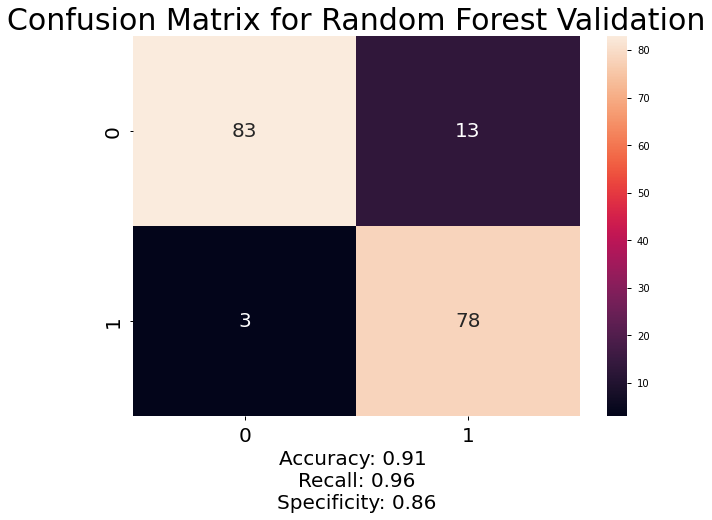

In [570]:
assess(y_valid,preds_rf_training,'Random Forest Validation')

In [300]:
oob_preds = rf.oob_decision_function_
oob_labels = np.argmax(oob_preds,axis=1)
print("OOB Accuracy: {0:.2f}".format(accuracy_score(y_train, oob_labels)))
print("Training Accuracy: {0:.2f}".format(accuracy_score(y_train, rf.predict(X_train))))

OOB Accuracy: 0.90
Training Accuracy: 1.00


In [301]:
accuracy_score(y_train, oob_labels)

0.8981612446958982

In [302]:
confused_oob = np.where(y_train!=oob_labels)

In [303]:
confused_oob

(array([  9,  16,  20,  28,  79,  86, 109, 114, 141, 148, 154, 160, 165,
        178, 201, 205, 209, 217, 235, 243, 249, 254, 267, 305, 319, 322,
        323, 341, 351, 353, 363, 382, 383, 384, 396, 417, 421, 424, 440,
        443, 452, 461, 467, 469, 482, 507, 537, 538, 540, 545, 550, 554,
        559, 562, 563, 567, 592, 600, 605, 607, 611, 633, 644, 652, 654,
        656, 663, 674, 678, 688, 690, 697]),)

In [304]:
all_importances = rf.feature_importances_
all_std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
all_indices = np.argsort(all_importances)[::-1]

In [305]:
all_importances.shape

(10097,)

In [520]:
all_feature_importances_ranked = pd.DataFrame({'Importance': all_importances, 'Feature': feature_names})
all_feature_importances_ranked = all_feature_importances_ranked.sort_values(by='Importance', ascending=False)

In [521]:
all_feature_importances_ranked

,Importance,Feature
1709,0.013475,Larp1b_chr3_+_40990200_40990310
4935,0.012824,Usp3_chr9_-_66449794_66449895
4840,0.009249,Arhgef12_chr9_-_42955559_42955583
2078,0.008929,Dio1_chr4_-_107154793_107154937
1609,0.008527,Abcd3_chr3_-_121570645_121570715
...,...,...
5177,0.000000,Gm29909_chr9_+_43526739_43526836
5180,0.000000,Ccdc153_chr9_+_44154310_44154430
5194,0.000000,Usp28_chr9_+_48912807_48912940
5195,0.000000,Usp28_chr9_+_48919728_48919815


In [524]:
all_feature_importances_ranked.reset_index(inplace=True)

In [525]:
all_feature_importances_ranked

,index,Importance,Feature
0,1709,0.013475,Larp1b_chr3_+_40990200_40990310
1,4935,0.012824,Usp3_chr9_-_66449794_66449895
2,4840,0.009249,Arhgef12_chr9_-_42955559_42955583
3,2078,0.008929,Dio1_chr4_-_107154793_107154937
4,1609,0.008527,Abcd3_chr3_-_121570645_121570715
...,...,...,...
10092,5177,0.000000,Gm29909_chr9_+_43526739_43526836
10093,5180,0.000000,Ccdc153_chr9_+_44154310_44154430
10094,5194,0.000000,Usp28_chr9_+_48912807_48912940
10095,5195,0.000000,Usp28_chr9_+_48919728_48919815


In [526]:
all_feature_importances_ranked.shape

(10097, 3)

In [527]:
importances_array = all_feature_importances_ranked[['index']].to_numpy()

In [528]:
importances_array.shape

(10097, 1)

In [529]:
importances_array = importances_array.reshape(10097,)

In [530]:
sorted_X_train = X_train[:,importances_array]

In [531]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,10087,10088,10089,10090,10091,10092,10093,10094,10095,10096
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.666667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.916667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.272727,0.780000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,1.0,0.0,0.0,0.0,0.250000,0.484375,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
703,0.0,0.0,0.0,0.0,0.0,0.294118,0.805556,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.6000,0.0,1.0,0.0,0.0,0.0
704,0.0,0.0,0.0,0.0,0.0,0.238095,0.688889,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
705,0.0,0.0,0.0,0.0,0.0,0.379310,0.772727,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0000,0.0,0.0,0.0,0.0,0.0


In [532]:
pd.DataFrame(sorted_X_train)

,0,1,2,3,4,5,6,7,8,9,...,10087,10088,10089,10090,10091,10092,10093,10094,10095,10096
0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.000000,1.0,1.0,1.0,0.298077,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,0.0,1.000000,1.0,1.0,1.0,1.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703,0.0,1.0,0.965812,0.0,0.0,0.0,0.000000,1.0,0.0,0.616570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,0.0,1.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.818182,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
705,0.0,1.0,1.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [533]:
sorted_X_train.shape

(707, 10097)

In [534]:
top10pct = round(np.shape(sorted_X_train)[1]*0.1) #top 10% of exons

In [535]:
top10pct

1010

In [536]:
X_train_filtered = sorted_X_train[:,0:top10pct]

In [537]:
sorted_X_valid = X_valid[:,importances_array]
sorted_X_test = X_test[:,importances_array]

In [538]:
X_valid_filtered = sorted_X_valid[:,0:top10pct]
X_test_filtered = sorted_X_test[:,0:top10pct]

In [539]:
all_feature_importances_ranked.to_csv('teich_rf_all_feature_importances_ranked.csv')

Feature Selection with Boruta for RF

In [209]:
from boruta import BorutaPy

In [210]:
feat_selector = BorutaPy(rf, n_estimators=600, verbose=2, random_state=20)


In [211]:
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10097
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10097
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10097
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10097
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10097
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10097
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10097
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	238
Rejected: 	9859
Iteration: 	9 / 100
Confirmed: 	39
Tentative: 	199
Rejected: 	9859
Iteration: 	10 / 100
Confirmed: 	39
Tentative: 	199
Rejected: 	9859
Iteration: 	11 / 100
Confirmed: 	39
Tentative: 	199
Rejected: 	9859
Iteration: 	12 / 100
Confirmed: 	39
Tentative: 	160
Rejected: 	9898
Iteration: 	13 / 100
Confirmed: 	39
Tentative: 	160
Rejected: 	9898
Iteration: 	14 / 100
Confirmed: 	39
Tentative: 	160
Rejected: 	9898
Iteration: 	15 / 100
Confirmed: 	39
Tentative: 	160
Rejected: 	9898
Iter

BorutaPy(estimator=RandomForestClassifier(n_estimators=600, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7F8024756340),
         n_estimators=600, random_state=RandomState(MT19937) at 0x7F8024756340,
         verbose=2)

In [221]:
feat_selector.support_

array([False, False, False, ..., False, False, False])

In [224]:
sum(feat_selector.support_==True)

39

In [238]:
features_ranked = pd.DataFrame({'Ranking': feat_selector.ranking_, 'Feature': feature_names})
features_ranked.sort_values(by='Ranking')

,Ranking,Feature
620,1,Dnajc1_chr2_-_18321168_18321215
2079,1,Lrp8os2_chr4_-_107667959_107668143
2078,1,Dio1_chr4_-_107154793_107154937
1709,1,Larp1b_chr3_+_40990200_40990310
1438,1,1700010I02Rik_chr3_-_8010259_8010399
...,...,...
5935,9298,Hmmr_chr11_-_40596718_40596895
5938,9298,Gabrg2_chr11_-_41804796_41804820
5939,9298,Pttg1_chr11_-_43311854_43312092
5947,9298,Cnot6_chr11_-_49570747_49570978


In [232]:
to_keep = pd.DataFrame({'Keep': feat_selector.support_, 'Feature': feature_names})

In [233]:
to_keep.to_csv('boruta_features_to_keep.csv')

In [239]:
features_ranked.to_csv('boruta_features_ranked.csv')

In [271]:
# call transform() on X to filter it down to selected features
X_train_filtered = feat_selector.transform(X_train)
X_valid_filtered = feat_selector.transform(X_valid)

feature_names_reshaped = np.reshape(feature_names, (1,10097))
feature_names_filtered = feat_selector.transform(feature_names_reshaped)

In [272]:
pd.DataFrame(X_train_filtered)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.500000,0.0,0.000000,1.0,0.652893,0.0,1.0,0.571429
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.500000,1.0,0.000000,0.0,0.000000,0.0,1.0,0.000000
2,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0,1.0,...,0.000000,0.777778,0.500000,1.0,0.298077,1.0,0.923077,1.0,1.0,0.648148
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.500000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.580645,1.0,1.0,...,0.000000,0.267857,0.507246,1.0,1.000000,1.0,0.654135,0.0,1.0,0.615646
703,0.0,1.0,0.8,1.0,0.0,0.0,0.0,0.000000,1.0,1.0,...,0.616570,0.264706,0.500000,1.0,0.000000,0.0,0.000000,0.0,1.0,0.630435
704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,...,0.818182,0.181818,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.600000
705,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,...,0.666667,0.121212,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.581395


In [246]:
rf_chosen = RandomForestClassifier(n_estimators=600, oob_score=True)
rf_chosen.fit(X_train_filtered,y_train)
preds_rf_chosen = rf_chosen.predict(X_valid_filtered)

In [247]:
accuracy_score(y_valid,preds_rf_chosen)

0.9265536723163842

array([[84, 12],
       [ 1, 80]])

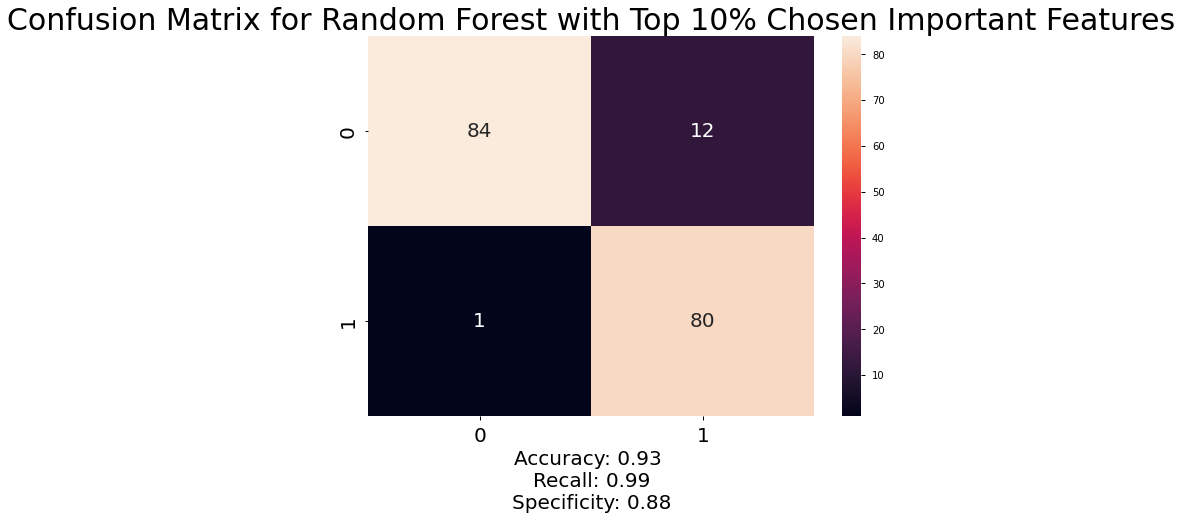

In [569]:
assess(y_valid,preds_rf_chosen,'Random Forest with Top 10% Chosen Important Features')

In [249]:
oob_preds_chosen = rf_chosen.oob_decision_function_
oob_labels_chosen = np.argmax(oob_preds_chosen,axis=1)
print("OOB Accuracy: {0:.2f}".format(accuracy_score(y_train, oob_labels_chosen)))
print("Training Accuracy: {0:.2f}".format(accuracy_score(y_train, rf_chosen.predict(X_train_filtered))))

OOB Accuracy: 0.92
Training Accuracy: 0.99


In [257]:
pd.DataFrame(X_train_filtered)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.500000,0.0,0.000000,1.0,0.652893,0.0,1.0,0.571429
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.500000,1.0,0.000000,0.0,0.000000,0.0,1.0,0.000000
2,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0,1.0,...,0.000000,0.777778,0.500000,1.0,0.298077,1.0,0.923077,1.0,1.0,0.648148
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.500000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.580645,1.0,1.0,...,0.000000,0.267857,0.507246,1.0,1.000000,1.0,0.654135,0.0,1.0,0.615646
703,0.0,1.0,0.8,1.0,0.0,0.0,0.0,0.000000,1.0,1.0,...,0.616570,0.264706,0.500000,1.0,0.000000,0.0,0.000000,0.0,1.0,0.630435
704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,...,0.818182,0.181818,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.600000
705,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,...,0.666667,0.121212,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.581395


In [250]:
importances = rf_chosen.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [282]:
feature_names_filtered_rs = np.reshape(feature_names_filtered, (39,))

In [289]:
feature_importances_ranked = pd.DataFrame({'Importance': importances, 'Feature': feature_names_filtered_rs})
feature_importances_ranked.sort_values(by='Importance', ascending=False)

,Importance,Feature
24,0.090894,Usp3_chr9_-_66449794_66449895
6,0.075825,Larp1b_chr3_+_40990200_40990310
16,0.058206,Clip1_chr5_-_123780481_123780679
5,0.049237,Abcd3_chr3_-_121570645_121570715
38,0.046930,Cmtr1_chr17_+_29910218_29910398
22,0.041192,Arhgef12_chr9_-_42955559_42955583
29,0.040965,2610307P16Rik_chr13_-_28895099_28895191
12,0.040802,Dio1_chr4_-_107154793_107154937
10,0.032562,Ankrd13c_chr3_+_157700233_157700395
15,0.031713,Cabp1_chr5_-_115318846_115319030


In [290]:
feature_importances_ranked.to_csv('boruta_feature_importances_ranked.csv')

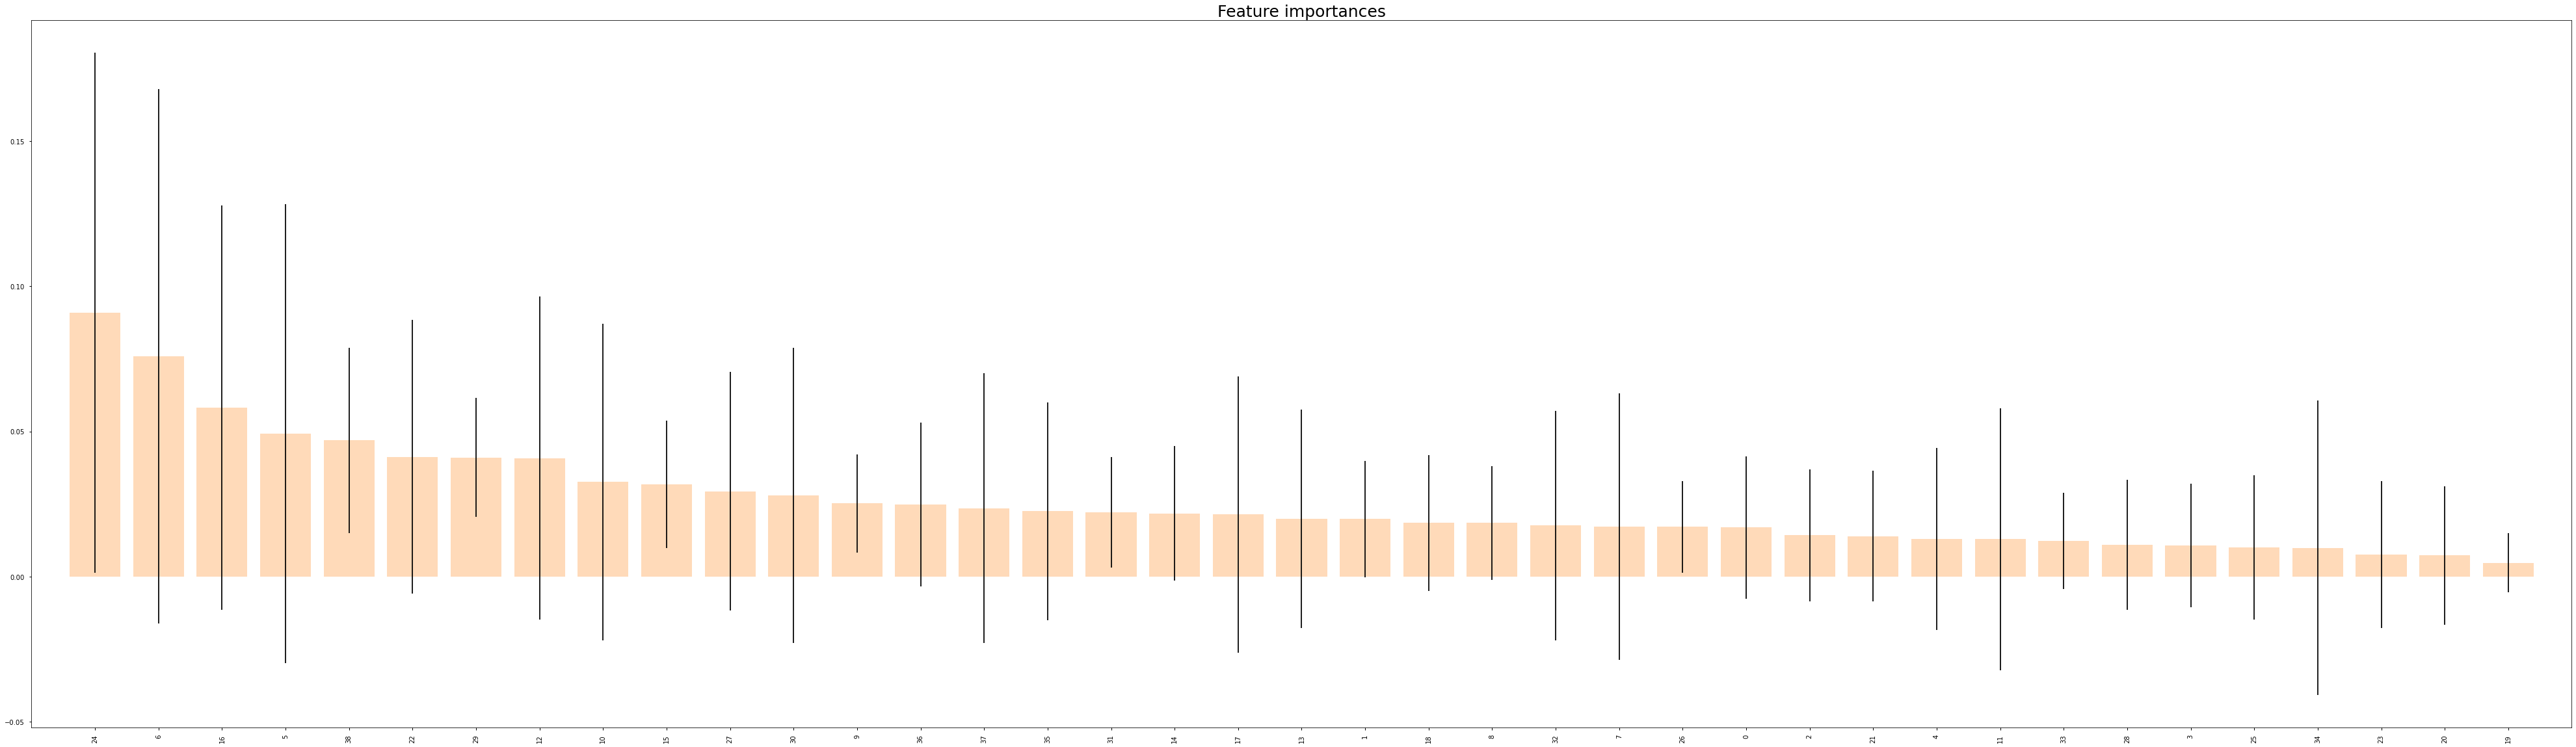

In [274]:
plt.figure(figsize=(70,20))
plt.style.use('seaborn-notebook')
plt.title("Feature importances", fontsize=25)
plt.bar(range(X_train_filtered.shape[1]), importances[indices],
       color="peachpuff", yerr=std[indices], align="center")
plt.xticks(range(X_train_filtered.shape[1]), indices,rotation=90)
plt.xlim([-1, X_train_filtered.shape[1]])
plt.show()

In [253]:
for f in range(X_train_filtered.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 24 (0.090894)
2. feature 6 (0.075825)
3. feature 16 (0.058206)
4. feature 5 (0.049237)
5. feature 38 (0.046930)
6. feature 22 (0.041192)
7. feature 29 (0.040965)
8. feature 12 (0.040802)
9. feature 10 (0.032562)
10. feature 15 (0.031713)
11. feature 27 (0.029359)
12. feature 30 (0.027897)
13. feature 9 (0.025209)
14. feature 36 (0.024862)
15. feature 37 (0.023532)
16. feature 35 (0.022538)
17. feature 31 (0.022202)
18. feature 14 (0.021726)
19. feature 17 (0.021356)
20. feature 13 (0.019924)
21. feature 1 (0.019796)
22. feature 18 (0.018468)
23. feature 8 (0.018452)
24. feature 32 (0.017613)
25. feature 7 (0.017247)
26. feature 26 (0.017153)
27. feature 0 (0.016878)
28. feature 2 (0.014255)
29. feature 21 (0.013892)
30. feature 4 (0.012933)
31. feature 11 (0.012865)
32. feature 33 (0.012201)
33. feature 28 (0.011002)
34. feature 3 (0.010740)
35. feature 25 (0.010040)
36. feature 34 (0.009877)
37. feature 23 (0.007602)
38. feature 20 (0.007271)
39. feature 19 (0.004783)


Deep Network

Test one

In [310]:
from numpy import loadtxt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd

In [343]:
model = Sequential()
model.add(Dense(12, input_shape=(39,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [344]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [345]:
model.fit(X_train_filtered, y_train, epochs=150, batch_size=10)

Epoch 1/150
71/71 [==============================] - 0s 959us/step - loss: 0.5343 - accuracy: 0.7086
Epoch 2/150
71/71 [==============================] - 0s 1ms/step - loss: 0.4092 - accuracy: 0.8430
Epoch 3/150
71/71 [==============================] - 0s 1ms/step - loss: 0.2864 - accuracy: 0.9024
Epoch 4/150
71/71 [==============================] - 0s 1ms/step - loss: 0.2296 - accuracy: 0.9066
Epoch 5/150
71/71 [==============================] - 0s 1ms/step - loss: 0.2069 - accuracy: 0.9151
Epoch 6/150
71/71 [==============================] - 0s 1ms/step - loss: 0.1936 - accuracy: 0.9052
Epoch 7/150
71/71 [==============================] - 0s 1ms/step - loss: 0.1834 - accuracy: 0.9194
Epoch 8/150
71/71 [==============================] - 0s 1ms/step - loss: 0.1776 - accuracy: 0.9180
Epoch 9/150
71/71 [==============================] - 0s 1ms/step - loss: 0.1717 - accuracy: 0.9208
Epoch 10/150
71/71 [==============================] - 0s 1ms/step - loss: 0.1670 - accuracy: 0.9250
Epoch 1

In [348]:
_, accuracy = model.evaluate(X_valid_filtered, y_valid)

6/6 [==============================] - 0s 1ms/step - loss: 0.8075 - accuracy: 0.8814


Try Hyperparameter Tuning

In [349]:
import tensorflow as tf
from tensorflow import keras

In [350]:
import keras_tuner as kt

In [351]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(39,)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [352]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [353]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [355]:
tuner.search(X_train_filtered, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 44 Complete [00h 00m 01s]
val_accuracy: 0.5281690359115601

Best val_accuracy So Far: 0.9154929518699646
Total elapsed time: 00h 00m 03s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 0.01.



In [356]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_filtered, y_train, epochs = 50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch))+1
print('Best epoch: %d' %(best_epoch,))

Epoch 1/50
18/18 [==============================] - 0s 9ms/step - loss: 0.6803 - accuracy: 0.7947 - val_loss: 0.2729 - val_accuracy: 0.8732
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9133 - val_loss: 0.2257 - val_accuracy: 0.8873
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 0.1830 - accuracy: 0.9186 - val_loss: 0.2223 - val_accuracy: 0.8944
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1710 - accuracy: 0.9292 - val_loss: 0.2043 - val_accuracy: 0.9155
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1451 - accuracy: 0.9434 - val_loss: 0.2023 - val_accuracy: 0.9085
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1267 - accuracy: 0.9398 - val_loss: 0.2025 - val_accuracy: 0.9155
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.1207 - accuracy: 0.9487 - val_loss: 0.2969 - val_accuracy: 0.8873
Epoch 8/50
18/18 [==

In [357]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train_filtered, y_train, epochs=21, validation_split=0.2)

Epoch 1/21
18/18 [==============================] - 1s 22ms/step - loss: 0.5658 - accuracy: 0.7841 - val_loss: 0.2357 - val_accuracy: 0.9014
Epoch 2/21
18/18 [==============================] - 0s 5ms/step - loss: 0.2125 - accuracy: 0.9168 - val_loss: 0.2607 - val_accuracy: 0.8803
Epoch 3/21
18/18 [==============================] - 0s 5ms/step - loss: 0.1755 - accuracy: 0.9168 - val_loss: 0.2090 - val_accuracy: 0.9085
Epoch 4/21
18/18 [==============================] - 0s 4ms/step - loss: 0.1553 - accuracy: 0.9327 - val_loss: 0.2118 - val_accuracy: 0.9225
Epoch 5/21
18/18 [==============================] - 0s 4ms/step - loss: 0.1415 - accuracy: 0.9398 - val_loss: 0.2101 - val_accuracy: 0.9225
Epoch 6/21
18/18 [==============================] - 0s 4ms/step - loss: 0.1287 - accuracy: 0.9451 - val_loss: 0.2222 - val_accuracy: 0.9225
Epoch 7/21
18/18 [==============================] - 0s 4ms/step - loss: 0.1196 - accuracy: 0.9540 - val_loss: 0.2245 - val_accuracy: 0.9085
Epoch 8/21
18/18 [=

In [358]:
eval_result = hypermodel.evaluate(X_valid_filtered, y_valid)
print("[test loss, test accuracy]:", eval_result)

6/6 [==============================] - 0s 1ms/step - loss: 0.3814 - accuracy: 0.9096
[test loss, test accuracy]: [0.3814166188240051, 0.909604549407959]


In [339]:
eval_result = hypermodel.evaluate(X_valid_filtered, y_valid)
print("[test loss, test accuracy]:", eval_result)

6/6 [==============================] - 0s 3ms/step - loss: 0.1500 - accuracy: 0.9435
[test loss, test accuracy]: [0.1500258892774582, 0.9435028433799744]


Test parameters with GridSearchCV

In [359]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

In [361]:
def create_model():
	model = Sequential()
	model.add(Dense(12, input_shape=(10097,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [363]:
# fix random seed for reproducibility
seed = 20
tf.random.set_seed(seed)

In [364]:
model = KerasClassifier(model=create_model, verbose=0)

In [366]:
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]

In [367]:
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [368]:
grid_result = grid.fit(X_train, y_train)

2022-07-10 17:14:24.170267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 17:14:24.171550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 17:14:24.172418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [369]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.915134 using {'batch_size': 20, 'epochs': 10}
0.913710 (0.007333) with: {'batch_size': 10, 'epochs': 10}
0.896760 (0.011005) with: {'batch_size': 10, 'epochs': 50}
0.889662 (0.007127) with: {'batch_size': 10, 'epochs': 100}
0.915134 (0.003464) with: {'batch_size': 20, 'epochs': 10}
0.909478 (0.001914) with: {'batch_size': 20, 'epochs': 50}
0.898179 (0.014975) with: {'batch_size': 20, 'epochs': 100}
0.905211 (0.012350) with: {'batch_size': 40, 'epochs': 10}
0.898149 (0.006213) with: {'batch_size': 40, 'epochs': 50}
0.900980 (0.013181) with: {'batch_size': 40, 'epochs': 100}
0.908036 (0.013317) with: {'batch_size': 60, 'epochs': 10}
0.901004 (0.007029) with: {'batch_size': 60, 'epochs': 50}
0.900998 (0.011056) with: {'batch_size': 60, 'epochs': 100}
0.899561 (0.007417) with: {'batch_size': 80, 'epochs': 10}
0.902380 (0.016029) with: {'batch_size': 80, 'epochs': 50}
0.899555 (0.010787) with: {'batch_size': 80, 'epochs': 100}
0.895306 (0.013343) with: {'batch_size': 100, 'epochs': 

In [370]:
def create_model_opt():
	model = Sequential()
	model.add(Dense(12, input_shape=(10097,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	return model

In [381]:
model = KerasClassifier(model=create_model_opt, loss="binary_crossentropy", epochs=100, batch_size=10, verbose=0)

In [382]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [383]:
grid_result = grid.fit(X_train, y_train)

In [384]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.913716 using {'optimizer': 'SGD'}
0.913716 (0.010605) with: {'optimizer': 'SGD'}
0.895324 (0.005454) with: {'optimizer': 'RMSprop'}
0.913698 (0.014143) with: {'optimizer': 'Adagrad'}
0.736964 (0.039017) with: {'optimizer': 'Adadelta'}
0.903823 (0.003905) with: {'optimizer': 'Adam'}
0.909472 (0.004092) with: {'optimizer': 'Adamax'}
0.901004 (0.013894) with: {'optimizer': 'Nadam'}


Best: 0.913728 using {'optimizer': 'RMSprop'}
0.896742 (0.002210) with: {'optimizer': 'SGD'}
0.913728 (0.005164) with: {'optimizer': 'RMSprop'}
0.830250 (0.010697) with: {'optimizer': 'Adagrad'}
0.533255 (0.009602) with: {'optimizer': 'Adadelta'}
0.908042 (0.012325) with: {'optimizer': 'Adam'}
0.888256 (0.014017) with: {'optimizer': 'Adamax'}
0.909466 (0.013174) with: {'optimizer': 'Nadam'}

In [385]:
model = KerasClassifier(model=create_model, loss="binary_crossentropy", optimizer="RMSprop", epochs=10, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

In [386]:
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [387]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.916534 using {'optimizer__learning_rate': 0.2, 'optimizer__momentum': 0.4}
0.900974 (0.010738) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.909478 (0.001914) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.910879 (0.007089) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.902386 (0.018089) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.902404 (0.003465) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
0.909454 (0.012343) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}
0.909466 (0.005470) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}
0.906647 (0.010381) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.909466 (0.007339) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
0.902392 (0.006205) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.915116 (0.015198) w

In [398]:
def create_model_init(init_mode='uniform'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(10097,), kernel_initializer=init_mode, activation='relu'))
	model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
	return model

In [399]:
model = KerasClassifier(model=create_model_init, epochs=10, batch_size=20, verbose=0)

In [400]:
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [401]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.913710 using {'model__init_mode': 'glorot_normal'}
0.909454 (0.011331) with: {'model__init_mode': 'uniform'}
0.908060 (0.005323) with: {'model__init_mode': 'lecun_uniform'}
0.906635 (0.007097) with: {'model__init_mode': 'normal'}
0.543142 (0.001088) with: {'model__init_mode': 'zero'}
0.913710 (0.005462) with: {'model__init_mode': 'glorot_normal'}
0.898167 (0.005897) with: {'model__init_mode': 'glorot_uniform'}
0.908048 (0.008871) with: {'model__init_mode': 'he_normal'}
0.908054 (0.004190) with: {'model__init_mode': 'he_uniform'}


In [409]:
def create_model_act(activation='relu'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(10097,), kernel_initializer='glorot_normal', activation=activation))
	model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
	return model

In [410]:
model = KerasClassifier(model=create_model_act, epochs=10, batch_size=20, verbose=0)

In [411]:
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [412]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.909478 using {'model__activation': 'tanh'}
0.906641 (0.003630) with: {'model__activation': 'softmax'}
0.902398 (0.003638) with: {'model__activation': 'softplus'}
0.905229 (0.004096) with: {'model__activation': 'softsign'}
0.900986 (0.002201) with: {'model__activation': 'relu'}
0.909478 (0.001914) with: {'model__activation': 'tanh'}
0.899531 (0.023287) with: {'model__activation': 'sigmoid'}
0.903805 (0.008878) with: {'model__activation': 'hard_sigmoid'}
0.902416 (0.005814) with: {'model__activation': 'linear'}


In [418]:
from tensorflow.keras.constraints import MaxNorm

In [424]:
def create_model_dr(dropout_rate, weight_constraint):
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(10097,), kernel_initializer='glorot_normal', activation='tanh', kernel_constraint=MaxNorm(weight_constraint)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
	return model

In [425]:
model = KerasClassifier(model=create_model_dr, epochs=10, batch_size=20, verbose=0)

In [426]:
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)

In [427]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [428]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.920766 using {'model__dropout_rate': 0.3, 'model__weight_constraint': 5.0}
0.900980 (0.010095) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.910879 (0.007089) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.912303 (0.005321) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.910897 (0.009099) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 4.0}
0.903805 (0.007408) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}
0.903787 (0.019255) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.910879 (0.007089) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.909472 (0.004092) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 3.0}
0.903811 (0.005441) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 4.0}
0.912303 (0.005321) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 5.0}
0.886801 (0.022528) with: {'model__dr

Best: 0.920778 using {'model__dropout_rate': 0.7, 'model__weight_constraint': 4.0}
Best: 0.920766 using {'model__dropout_rate': 0.3, 'model__weight_constraint': 5.0}

In [429]:
def create_model_neurons(neurons):
	# create model
	model = Sequential()
	model.add(Dense(neurons, input_shape=(10097,), kernel_initializer='glorot_normal', activation='tanh', kernel_constraint=MaxNorm(5)))
	model.add(Dropout(0.3))
	model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
	return model

In [430]:
model = KerasClassifier(model=create_model_neurons, epochs=10, batch_size=20, verbose=0)

In [432]:
neurons = [10, 50, 100, 200, 400, 600, 800, 1000]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

2022-07-10 17:57:45.229372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 17:57:45.230515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 17:57:45.230530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [433]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.915128 using {'model__neurons': 100}
0.912291 (0.008865) with: {'model__neurons': 10}
0.912285 (0.014546) with: {'model__neurons': 50}
0.915128 (0.003615) with: {'model__neurons': 100}
0.905205 (0.015807) with: {'model__neurons': 200}
0.909460 (0.008194) with: {'model__neurons': 400}
0.906647 (0.010381) with: {'model__neurons': 600}
0.912315 (0.005132) with: {'model__neurons': 800}
0.902410 (0.009094) with: {'model__neurons': 1000}


In [435]:
neurons = [50, 70, 90, 100, 110, 120, 130, 140, 150]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

2022-07-10 18:11:25.500198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 18:11:25.502964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 18:11:25.506322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [436]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.913716 using {'model__neurons': 110}
0.910885 (0.003623) with: {'model__neurons': 50}
0.910891 (0.006922) with: {'model__neurons': 70}
0.910891 (0.003464) with: {'model__neurons': 90}
0.909460 (0.013224) with: {'model__neurons': 100}
0.913716 (0.004087) with: {'model__neurons': 110}
0.913704 (0.010718) with: {'model__neurons': 120}
0.910891 (0.003464) with: {'model__neurons': 130}
0.910891 (0.000178) with: {'model__neurons': 140}
0.905211 (0.014157) with: {'model__neurons': 150}


In [437]:
def create_model_reg(regularizer_fn):
	# create model
	model = Sequential()
	model.add(Dense(110, input_shape=(10097,), kernel_initializer='glorot_normal', kernel_regularizer=regularizer_fn, activation='tanh', kernel_constraint=MaxNorm(5)))
	model.add(Dropout(0.3))
	model.add(Dense(1, kernel_initializer='glorot_normal', kernel_regularizer=regularizer_fn, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
	return model

In [438]:
model = KerasClassifier(model=create_model_reg, epochs=10, batch_size=20, verbose=0)

In [439]:
regularizer_fn = [l1(0.01), l2(0.01)]
param_grid = dict(model__regularizer_fn=regularizer_fn)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

2022-07-10 18:31:32.863225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 18:31:32.863633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 18:31:32.866662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [440]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.867081 using {'model__regularizer_fn': <keras.regularizers.L2 object at 0x7f8001874f10>}
0.626536 (0.132683) with: {'model__regularizer_fn': <keras.regularizers.L1 object at 0x7f8001899640>}
0.867081 (0.060090) with: {'model__regularizer_fn': <keras.regularizers.L2 object at 0x7f8001874f10>}


I will not use L2 or L1 regularization, only dropout

In [556]:
opt_model = Sequential()
opt_model.add(Dense(110, input_shape=(10097,), kernel_initializer='glorot_normal', activation='tanh', kernel_constraint=MaxNorm(5)))
opt_model.add(Dropout(0.3))
opt_model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))

In [557]:
opt_model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [558]:
opt_model.fit(X_train, y_train,  epochs=10, batch_size=20)

Epoch 1/10
36/36 [==============================] - 1s 13ms/step - loss: 0.5103 - accuracy: 0.7893
Epoch 2/10
36/36 [==============================] - 0s 12ms/step - loss: 0.1139 - accuracy: 0.9760
Epoch 3/10
36/36 [==============================] - 0s 12ms/step - loss: 0.1129 - accuracy: 0.9661
Epoch 4/10
36/36 [==============================] - 0s 13ms/step - loss: 0.0313 - accuracy: 0.9972
Epoch 5/10
36/36 [==============================] - 0s 13ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 6/10
36/36 [==============================] - 0s 13ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 7/10
36/36 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 8/10
36/36 [==============================] - 0s 13ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 9/10
36/36 [==============================] - 0s 13ms/step - loss: 4.8785e-04 - accuracy: 1.0000
Epoch 10/10
36/36 [==============================] - 0s 13ms/step - loss: 2.0320e-04 - accuracy: 1.0000


In [559]:
_, accuracy = opt_model.evaluate(X_valid, y_valid)

6/6 [==============================] - 0s 2ms/step - loss: 0.2814 - accuracy: 0.9379


In [560]:
_, accuracy = opt_model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.8959


In [561]:
def new_make_cm(cm, y_true, preds, name='name'):
    if (len(preds[preds==0]))!=0 :
        specificity = len(preds[(preds==0)&(y_true==0)])/(len(y_true[y_true==0]))
    else:
        specificity = 0
        
    sns.heatmap(cm, annot = True,fmt = 'd', annot_kws={"fontsize":20})
    plt.title('Confusion Matrix for {0}'.format(name), fontsize=30)
    plt.xlabel("Accuracy: {0:.2f} \nRecall: {1:.2f}\nSpecificity: {2:.2f}".format(accuracy_score(y_true,preds),
                                                                      recall_score(y_true, preds),
                                                                      specificity),fontsize= 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

In [562]:
preds_valid = (opt_model.predict(X_valid) > 0.5).astype("int32")

6/6 [==============================] - 0s 2ms/step


In [563]:
preds_valid = preds_valid.reshape(177,)

In [564]:
cm_valid = confusion_matrix(y_valid,preds_valid)

In [565]:
cm_valid

array([[87,  9],
       [ 2, 79]])

In [566]:
preds_valid.shape

(177,)

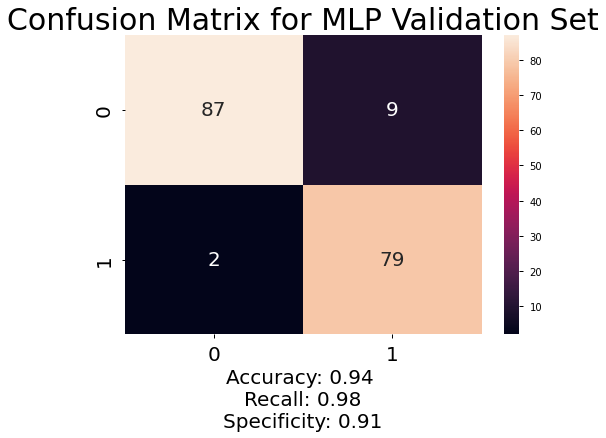

In [567]:
new_make_cm(cm_valid, y_valid, preds_valid, 'MLP Validation Set')

In [553]:
X_test.shape

(221, 10097)

7/7 [==============================] - 0s 2ms/step


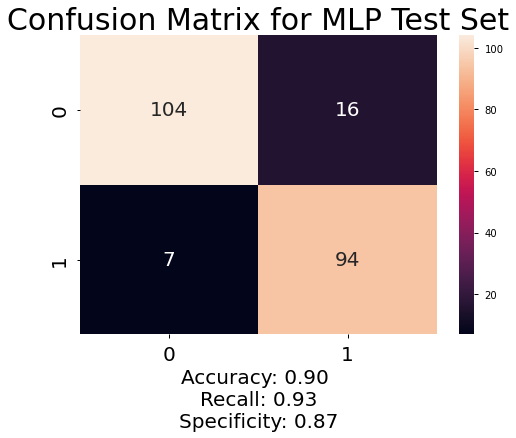

In [568]:
preds_test = (opt_model.predict(X_test) > 0.5).astype("int32")
preds_test = preds_test.reshape(221,)
cm_test = confusion_matrix(y_test,preds_test)
new_make_cm(cm_test, y_test, preds_test, 'MLP Test Set')

In [501]:
def add_roc(fpr,tpr,p, name, color):
    # add a line renderer with legend and line thickness
    p.line(fpr, tpr, legend=name, line_width=2, color=color)
    return 

In [506]:
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_valid,
                                             opt_model.predict(X_valid),
                                             pos_label=1)

6/6 [==============================] - 0s 2ms/step


In [517]:
p = figure(title="ROC Curve for MLP", x_axis_label='1-Specificity', y_axis_label='Sensitiviy')
p.line(fpr_mlp, tpr_mlp, line_width=2, legend='ROC for Single-Layered Network, AUC:{0:.2f}'.format(auc(fpr_mlp,tpr_mlp)), color='#e67e22')

#p.add_layout(legend='ROC for Single-Layered Network, AUC:{0:.2f}'.format(auc(fpr_mlp,tpr_mlp)))
p.legend.location = "bottom_right"
show(p)



Try with top 10% features

In [541]:
opt_model = Sequential()
opt_model.add(Dense(110, input_shape=(1010,), kernel_initializer='glorot_normal', activation='tanh', kernel_constraint=MaxNorm(5)))
opt_model.add(Dropout(0.3))
opt_model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))

In [542]:
opt_model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [543]:
opt_model.fit(X_train_filtered, y_train,  epochs=10, batch_size=20)

Epoch 1/10
36/36 [==============================] - 1s 3ms/step - loss: 0.4024 - accuracy: 0.8091
Epoch 2/10
36/36 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.9434
Epoch 3/10
36/36 [==============================] - 0s 3ms/step - loss: 0.1177 - accuracy: 0.9675
Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.9859
Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9887
Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9972
Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.9972
Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 1.0000
Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9958
Epoch 10/10
36/36 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 1.0000


In [544]:
_, accuracy = opt_model.evaluate(X_valid_filtered, y_valid)

6/6 [==============================] - 0s 1ms/step - loss: 0.2381 - accuracy: 0.9322


In [545]:
_, accuracy = opt_model.evaluate(X_test_filtered, y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.2279 - accuracy: 0.9231


In [547]:
X_valid_filtered.shape

(177, 1010)

6/6 [==============================] - 0s 2ms/step


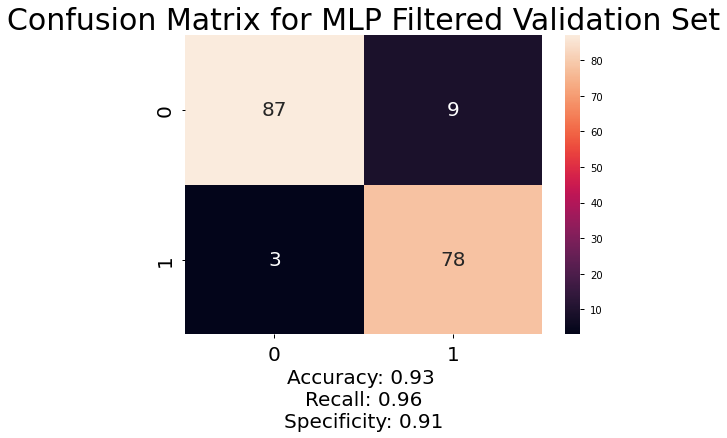

In [548]:
preds_valid = (opt_model.predict(X_valid_filtered) > 0.5).astype("int32")
preds_valid = preds_valid.reshape(177,)
cm_valid = confusion_matrix(y_valid,preds_valid)
new_make_cm(cm_valid, y_valid, preds_valid, 'MLP Filtered Validation Set')

In [549]:
X_test_filtered.shape

(221, 1010)

7/7 [==============================] - 0s 1ms/step


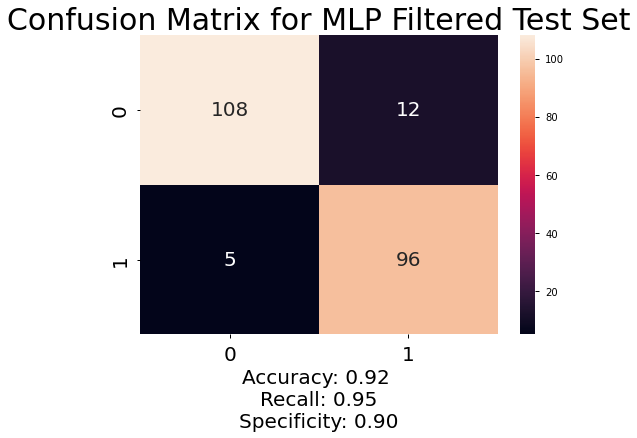

In [550]:
preds_test = (opt_model.predict(X_test_filtered) > 0.5).astype("int32")
preds_test = preds_test.reshape(221,)
cm_test = confusion_matrix(y_test,preds_test)
new_make_cm(cm_test, y_test, preds_test, 'MLP Filtered Test Set')

In [551]:
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_valid,
                                             opt_model.predict(X_valid_filtered),
                                             pos_label=1)

6/6 [==============================] - 0s 1ms/step


In [552]:
p = figure(title="ROC Curve for MLP Filtered", x_axis_label='1-Specificity', y_axis_label='Sensitiviy')
p.line(fpr_mlp, tpr_mlp, line_width=2, legend='ROC for Single-Layered Network, AUC:{0:.2f}'.format(auc(fpr_mlp,tpr_mlp)), color='#e67e22')

#p.add_layout(legend='ROC for Single-Layered Network, AUC:{0:.2f}'.format(auc(fpr_mlp,tpr_mlp)))
p.legend.location = "bottom_right"
show(p)

